In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import json 

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from utils_preprocessing import eis_dataframe_from_csv
from utils_preprocessing import process_batch_element_f
from utils_preprocessing import process_batch_element_zreal
from utils_preprocessing import process_batch_element_zimag
from utils_preprocessing import exclude_outlier

from utils import plot_freq_range
from utils import umap_plots

/home/joachimschaeffer/anaconda3/envs/eis-ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-14 13:13:02.623912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 13:13:02.888535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joachimschaeffer/anaconda3/envs/eis-ml/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-14 13:13:02.888592: I

In [2]:
# Load the csv into a data frame.
df = eis_dataframe_from_csv("data/train_data.csv")
df_test = eis_dataframe_from_csv("data/test_data.csv")
save_figs = 0

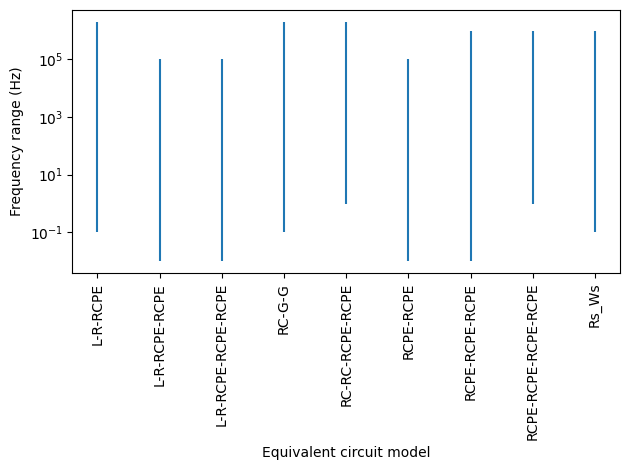

['L-R-RCPE' 'L-R-RCPE-RCPE' 'L-R-RCPE-RCPE-RCPE' 'RC-G-G'
 'RC-RC-RCPE-RCPE' 'RCPE-RCPE' 'RCPE-RCPE-RCPE' 'RCPE-RCPE-RCPE-RCPE'
 'Rs_Ws'] [ 9  4 15 23  3  0  5  8 13]
Maximal minimum freq: 10.0, minimal maximum freq: 100000.0


In [3]:
plot_freq_range(df, save=save_figs)

In [4]:
def interpolate_to_freq_range(df):
    ## Interpolate onto the largest frequency union to prevent data leakage
    interpolated_basis = np.geomspace(10, 1e5, num=30)

    df["f"] = df.apply(lambda x: process_batch_element_f(interpolated_basis), axis=1)
    df["zreal"] = df.apply(
        lambda x: process_batch_element_zreal(x.freq, x.Z, interpolated_basis), axis=1
    )
    df["zimag"] = df.apply(
        lambda x: process_batch_element_zimag(x.freq, x.Z, interpolated_basis), axis=1
    )

    # Sort the data frame to get the circuit names in alphabetical order
    df_sorted = df.sort_values(by=["Circuit"])
    return df_sorted

In [5]:
df_sorted = interpolate_to_freq_range(df)
df_test_sorted = interpolate_to_freq_range(df_test)

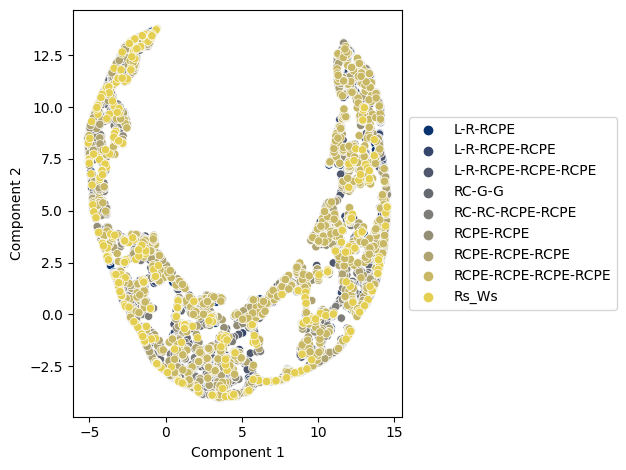

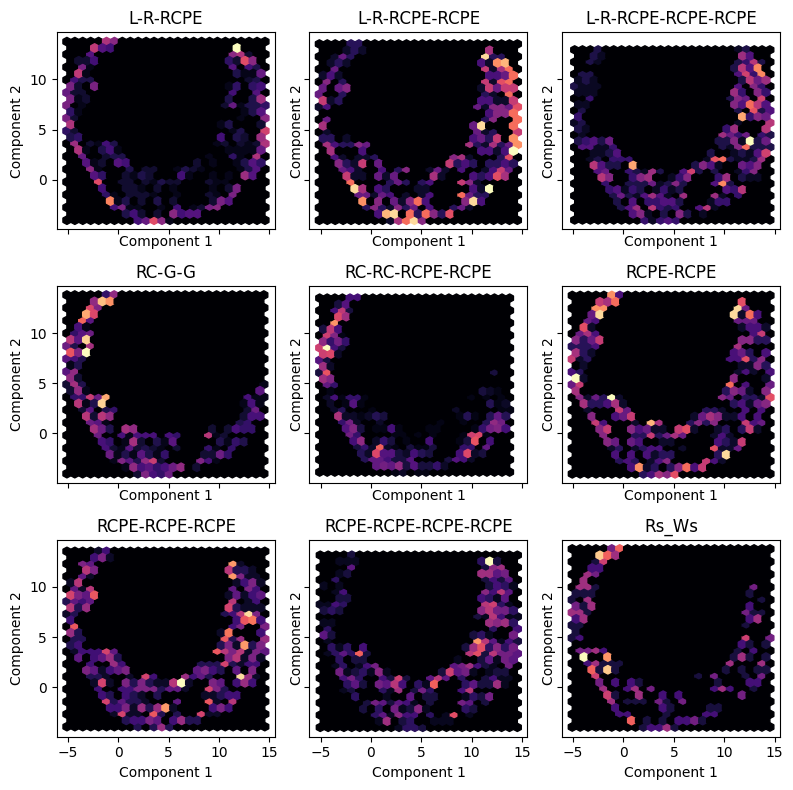

In [6]:
# Umap random state fixed (plots differ slightly from publication, because the seed was previously not fixed).
# Even though the seed is fixed, subple changes can occur (probabaly due to the stochastic nature of UMAP.)
umap_plots(df_sorted, save=save_figs, random_state=42)

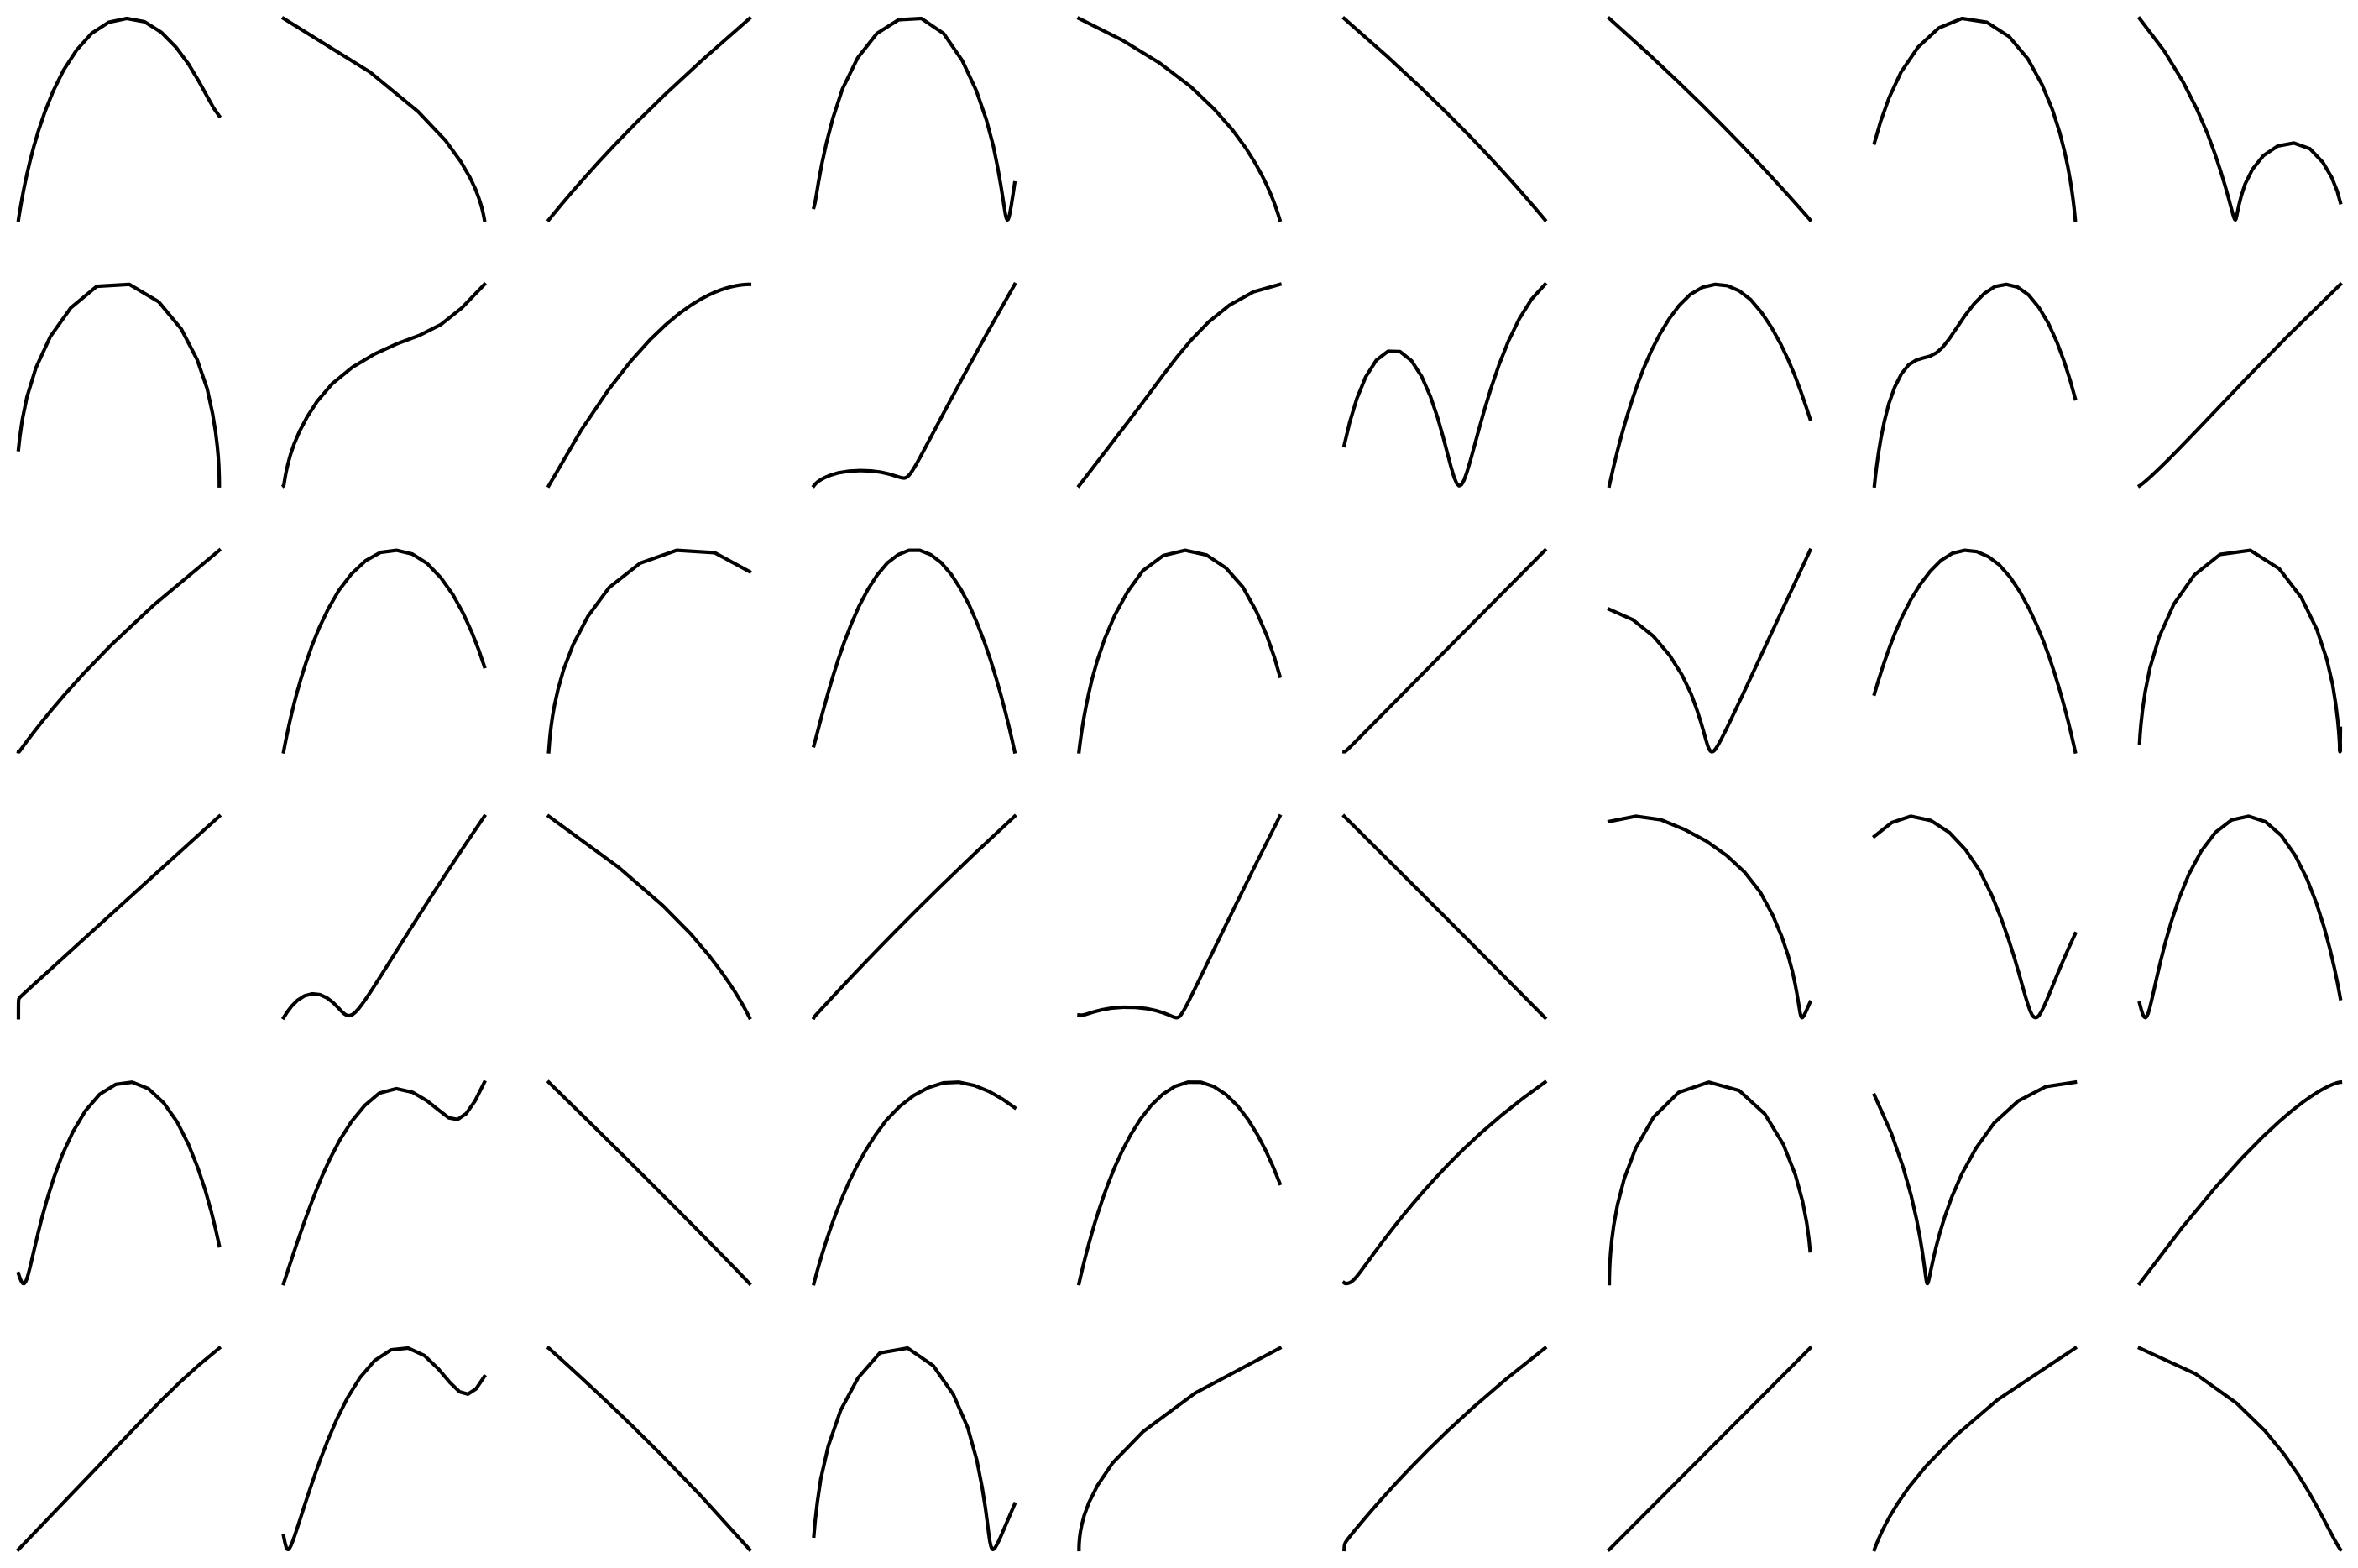

In [7]:
# Visualize data as images (used for the CNN)
rows = 6 
cols = 9 
fig, axs = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=(4*cols, 4*rows), frameon=False)
for i in range(rows):
    if i == 0:
        axs[i, 0].set_ylabel("zreal")
    for j in range(cols):
        axs[i, j].set_axis_off()
        axs[i, j].plot(df['zreal'][i*cols+j], -df['zimag'][i*cols+j], linewidth=3, color='black')

axs[i, j].set_xlabel('Frequency (Hz)')
if save_figs:
    fig.savefig('figures/eis_art.eps')
    fig.savefig('figures/eis_art.pdf')
plt.show()

Text(0.5, 1.0, 'All spectra')

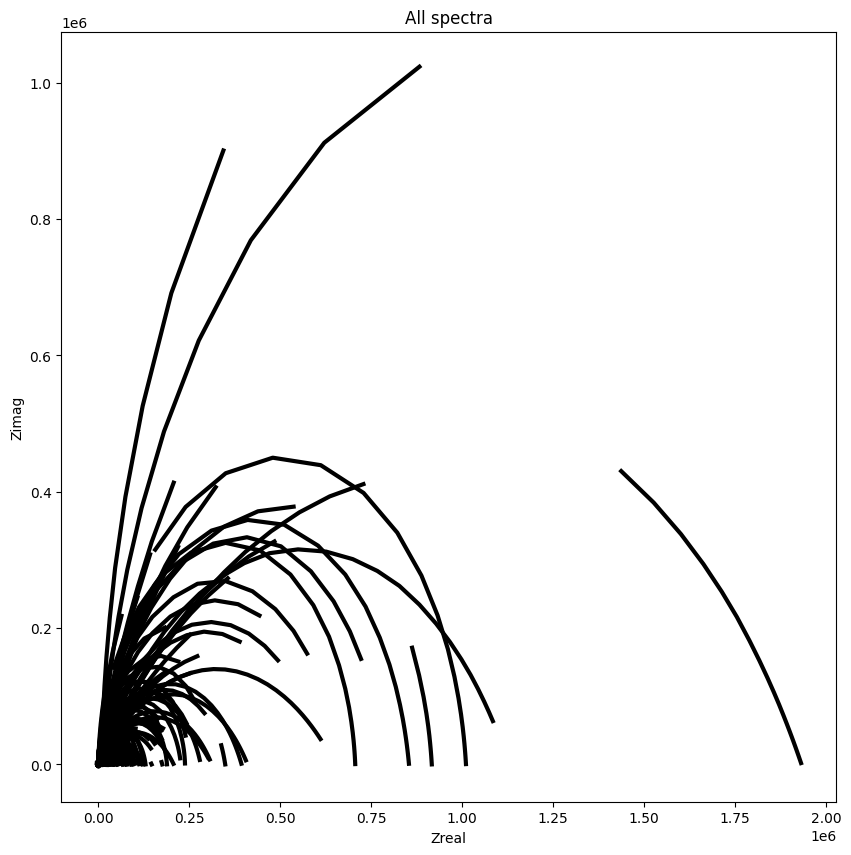

In [8]:
# Showcase outliers by plotting all spectra in a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(len(df)):
    ax.plot(df['zreal'][i], -df['zimag'][i], linewidth=3, color='black')
ax.set_xlabel('Zreal')
ax.set_ylabel('Zimag')
ax.set_title('All spectra')